# Experimental Design
***
## Magnetism

Import the necessary packages and code to generate the magnetism results.

In [1]:
%matplotlib inline

import numpy as np
import os, sys
# Add to system path to access experimental design code.
sys.path.append('../experimental-design')
sys.path.append('../experimental-design/models')

from scipy.optimize import differential_evolution

from magnetic import SampleYIG
from simulate import simulate_magnetic, reflectivity
from utils import save_plot

# Reduce size of plots for the notebook.
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

Get the fitted SLD profile and reflectivity curve for the experimentally-measured data sets of the magnetic model.

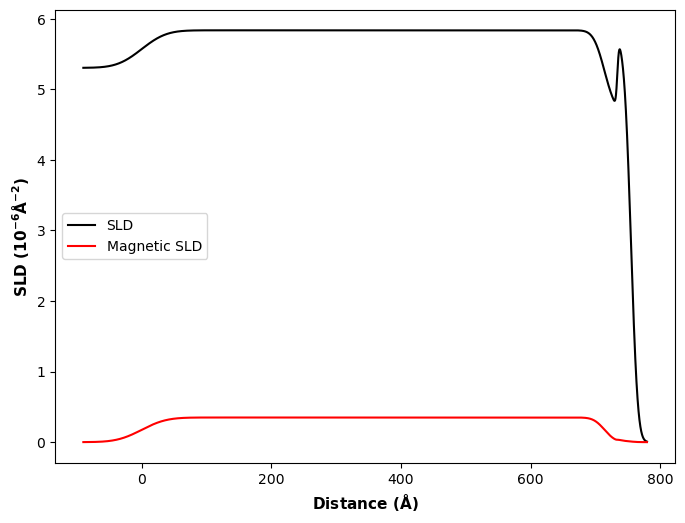

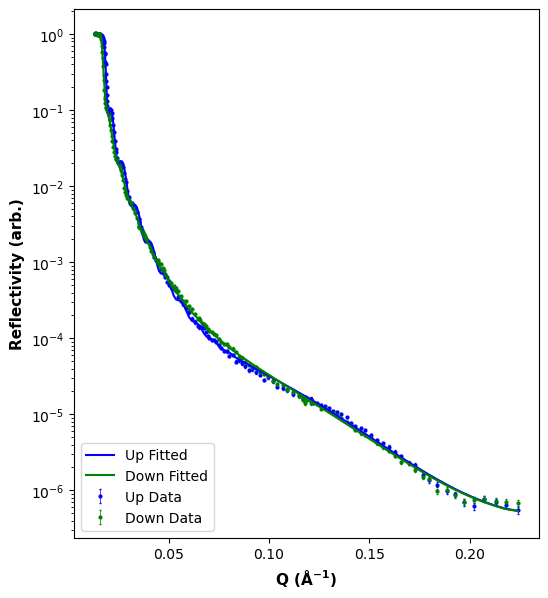

In [2]:
sample = SampleYIG()

# Add a 1 uB/atom magnetic moment in the platinum layer.
sample.pt_mag.value = 0.01638

save_path = './results'
sample.sld_profile(save_path)
sample.reflectivity_profile(save_path)

>>> 0/1200
>>> 150/1200
>>> 300/1200
>>> 450/1200
>>> 600/1200
>>> 750/1200
>>> 900/1200
>>> 1050/1200
YIG Thickness: 425.6
Pt Thickness: 26.36


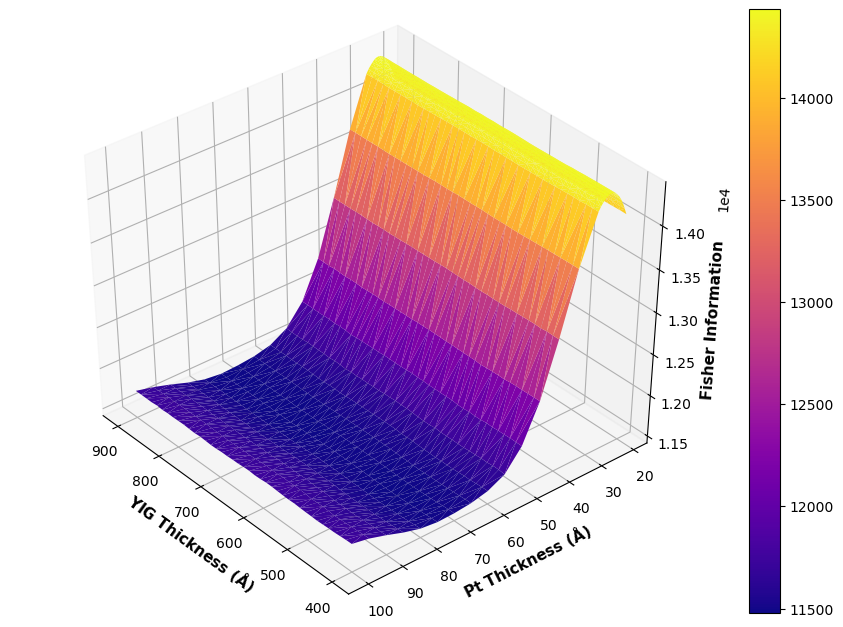

In [5]:
# Number of points and counting times for each angle to simulate.
angle_times = [(0.5, 100, 20),
               (1.0, 100, 40),
               (2.0, 100, 80)]

# Range of YIG and platinum layer thicknesses to calculate over.
yig_thick_range = np.linspace(400, 900, 60)
pt_thick_range = np.concatenate((np.linspace(21.5, 30, 25), np.linspace(30, 100, 25)))

# Iterate over each YIG and platinum layer thickness being considered.
x, y, infos = [], [], []
n = len(pt_thick_range)*len(yig_thick_range) # Number of calculations.
for i, yig_thick in enumerate(yig_thick_range):
    # Display progress.
    if i % 5 == 0:
        print('>>> {0}/{1}'.format(i*len(pt_thick_range), n))

    for pt_thick in pt_thick_range:
        # Calculate the Fisher information using current thicknesses.
        g = sample.underlayer_info(angle_times, yig_thick, pt_thick)

        infos.append(g[0,0])
        x.append(yig_thick)
        y.append(pt_thick)

# Create plot of YIG and platinum layer thicknesses versus Fisher information.
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111, projection='3d')

# Create the surface plot and add colour bar.
surface = ax.plot_trisurf(x, y, infos, cmap='plasma')
fig.colorbar(surface, fraction=0.046, pad=0.04)

ax.set_xlabel('$\mathregular{YIG\ Thickness\ (\AA)}$', fontsize=11, weight='bold')
ax.set_ylabel('$\mathregular{Pt\ Thickness\ (\AA)}$', fontsize=11, weight='bold')
ax.set_zlabel('Fisher Information', fontsize=11, weight='bold')
ax.ticklabel_format(axis='z', style='sci', scilimits=(0,0))

# Adjust the "view" of the 3D plot.
ax = plt.gca()
ax.view_init(elev=40, azim=140)

# Save the plot.
save_path = os.path.join(save_path, sample.name)
save_plot(fig, save_path, 'underlayer_choice')

# Find the YIG and Pt thicknesses with greatest Fisher information.
maximum = np.argmax(infos)
print('YIG Thickness: {}'.format(round(x[maximum], 1)))
print('Pt Thickness: {}'.format(round(y[maximum], 2)))

In [15]:
# Define the range of times to consider (1 to 100 hours here).
times = np.linspace(40, 4000, 100)

# Number of points and split of the total counting time for each angle to simulate.
angle_splits = [(0.5, 100, 1/7),
                (1.0, 100, 2/7),
                (2.0, 100, 4/7)]

def calc_log_ratios(pt_thick):
    """Calculates log ratio of likelihoods between two models, one with an
      induced moment in the YIG sample Pt layer and one with no moment, as
      a function of measurement time.

    Args:
        pt_thick (float): Pt layer thickness to use.

    """
    ratios = []
    # Iterate over each time being considered.
    for i, total_time in enumerate(times):
        # Display progress.
        if i % 5 == 25:
            print('>>> {0}/{1}'.format(i, len(times)))
        
        temp = []
        # Get the ratio for 100 simulated data sets using the time.
        for _ in range(20):
            # Define the number of points and times for each angle.
            angle_times = [(angle, points, split*total_time)
                           for angle, points, split in angle_splits]

            # Simulate data for the YIG sample with a 1 uB/atom magnetic
            # moment in the Pt layer.
            sample = SampleYIG()
            sample.pt_mag.value = 0.01638

            structure = sample.using_conditions(pt_thick=pt_thick)
            models, datasets = simulate_magnetic(structure, angle_times,
                                                 scale=1, bkg=5e-7, dq=2,
                                                 pp=True, pm=False,
                                                 mp=False, mm=True)

            # Calculate the log-likelihood of a model containing the
            # Pt layer magnetic moment.
            logl_1 = logl(models)

            # Calculate the log-likelihood of a model without the
            # Pt layer magnetic moment.
            sample.pt_mag.value = 0
            logl_2 = logl(models)

            # Record the ratio of likelihoods.
            ratio = logl_1-logl_2
            temp.append(ratio)
            
        # Record the median ratio.
        ratios.append(np.median(temp))
    
    return ratios

def logl(models):
    """Calculates the log-likelihood for a given list of `models`
       corresponding to simulated spin states.

    Args:
        models (list): models to calculate log-likelihood for.

    Returns:
        float: log-likelihood of given `models`.

    """
    # Extract the Q, R, dR and model R for the simulated spin states.
    q, r, dr, r_model = [], [] , [], []
    for model in models:
        probe = model.probe.xs[model.probe.spin_state]
        q.append(probe.Q)
        r.append(probe.R)
        dr.append(probe.dR)
        r_model.append(reflectivity(probe.Q, model))

    # Combine the data from each spin state.
    q = np.concatenate(q)
    r = np.concatenate(r)
    dr = np.concatenate(dr)
    r_model = np.concatenate(r_model)

    # Calculate the log-likelihood over all the models.
    return -0.5*np.sum(((r-r_model)/dr)**2 + np.log(2*np.pi*dr**2))

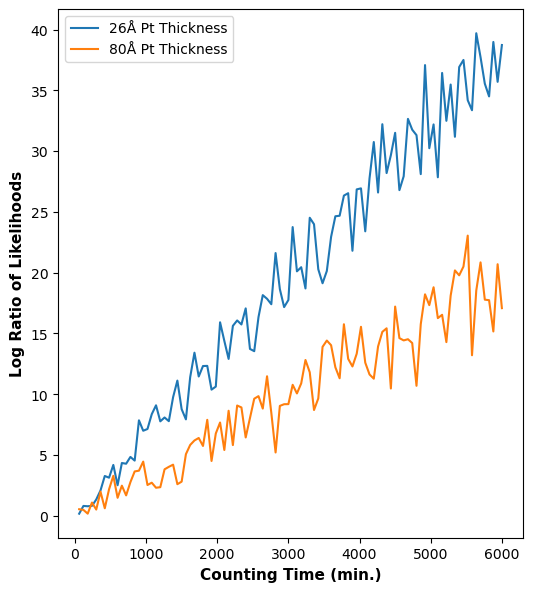

In [16]:
# Create the plot of counting time versus log ratio of likelihoods.
fig = plt.figure(figsize=(6,7))
ax = fig.add_subplot(111)

ax.plot(1.5*times, calc_log_ratios(26), label='26Å Pt Thickness')
ax.plot(1.5*times, calc_log_ratios(80), label='80Å Pt Thickness')

ax.set_xlabel('Counting Time (min.)', fontsize=11, weight='bold')
ax.set_ylabel('Log Ratio of Likelihoods', fontsize=11, weight='bold')
ax.legend()

# Save the plot.
save_path = os.path.join(save_path, 'YIG_sample')
save_plot(fig, save_path, 'log_ratios')